In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.utils import shuffle
import copy
from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [30]:
def draw(model, X, y):

    h = .02

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

# Semi-supervised learning

Załóżmy, że mamy 10 przykładów z etykietami i nie jesteśmy w stanie dostrczyć więcej etykiet. Mamy też dużo danych bez etykiet. Jak je wykorzystać?

# Toy example

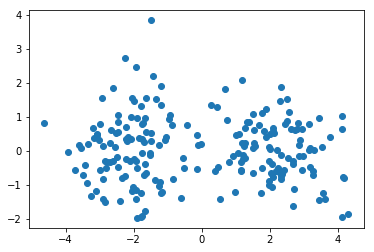

In [31]:


X, y = make_blobs(n_samples=210, centers = [[-2,0],[2,0]], random_state=42)
# X, y = make_moons(n_samples=200, noise=0.05, random_state=42)
y_save = copy.deepcopy(y)
X_save = copy.deepcopy(X)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

In [32]:


num_labels = 10
num_unlabeled = len(y_save)-num_labels
print(num_unlabeled)
print(num_labels)
random.seed(1)
inds_unlabeled = random.sample(range(len(y_save)), num_unlabeled)
y[inds_unlabeled] = -1


200
10


In [33]:
X_train = X_save[y>-1]
X_test = X_save[y == -1]
y_train = y_save[y > -1]
y_test = y_save[y == -1]

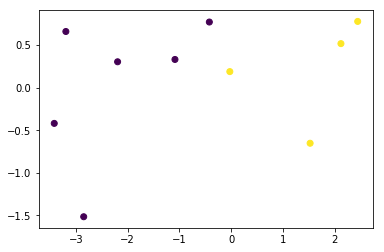

In [34]:
plt.scatter(X[y>=0][:,0], X[y>=0][:,1], c = y[y>=0])
plt.show()

ZADANIE: napisz klasę self-trainera, który sam etykietuje najbardziej pewne etykiety. 

In [35]:


class PseudoLabeler:
    def __init__(self, model, sample_rate=0.05, upper_bound = 1.0, seed=42):
        self.sample_rate = sample_rate
        self.upper_bound = upper_bound
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
    def fit(self, X, y):
        X_aug = X[y >= 0]
        y_aug = y[y >= 0]
        X_pool = X[y == -1]
        rate = self.sample_rate    
        num_labels = int(X_pool.shape[0] * self.sample_rate)
        while rate <= self.upper_bound:
            X_aug, y_aug, X_pool = self.pseudo_label(X_aug, y_aug, X_pool, num_labels)
            rate += self.sample_rate
        self.model.fit(X_aug, y_aug)
        return self
    
    def pseudo_label(self, X, y, X_pool, num_labels):
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        proba_labels = self.model.predict_proba(X_pool)
        pseudo_labels = self.model.predict(X_pool)
              
        # Take a subset of the pool set with pseudo-labels and append in onto the training set
        ind_selected = self.select_by_confidence2(proba_labels, num_labels)
        X_aug = np.vstack((X, X_pool[ind_selected]))
        y_aug = np.hstack((y, pseudo_labels[ind_selected]))
        X_pool = np.delete(X_pool, ind_selected, 0)

        return X_aug, y_aug, X_pool
    
    def select_by_sampling(self, proba, num_labels):
        return random.sample(range(len(proba)), num_labels)
    
    
    def select_by_confidence2(self, proba, num_labels):
        p_ind_sort = np.argsort(proba, axis = 0)[::-1]
        portion = int(num_labels/p_ind_sort.shape[1])
        inds = p_ind_sort[:portion, :].flatten().tolist()
        return inds
    
    def predict(self, X):
        return self.model.predict(X)
        


ZADANIE: Naucz self trainera

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model

model = PseudoLabeler(
    linear_model.LogisticRegression(C=1e5, random_state= 42)
)
model.fit(X, y)


In [37]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

1.0
0.98


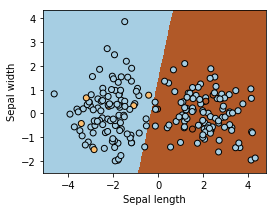

In [38]:
draw(model, X, y)

ZADANIE: Naucz zwykły klasyfikator

In [39]:
m2 = linear_model.LogisticRegression(C=1e5, random_state= 42)
m2.fit(X_train, y_train)
y_train_pred2 = m2.predict(X_train)
y_test_pred2 = m2.predict(X_test)

print(accuracy_score(y_train, y_train_pred2))
print(accuracy_score(y_test, y_test_pred2))


1.0
0.9


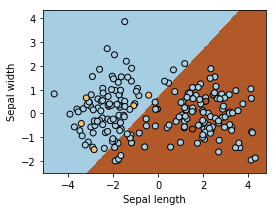

In [40]:
draw(m2, X, y)

# Real data

Weź zbiór digits i porównaj wyniki

In [53]:
from sklearn import datasets

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:500]]
y = digits.target[indices[:500]]
images = digits.images[indices[:500]]

In [54]:


y_save = copy.deepcopy(y)
X_save = copy.deepcopy(X)

num_labels = 30
num_unlabeled = len(y_save)-num_labels
print(num_unlabeled)
print(num_labels)
random.seed(1)
inds_unlabeled = random.sample(range(len(y_save)), num_unlabeled)
y[inds_unlabeled] = -1
len(set(y_save[y > -1]))

470
30


10

In [55]:
X_train = X_save[y>-1]
X_test = X_save[y == -1]
y_train = y_save[y > -1]
y_test = y_save[y == -1]

In [56]:
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model

model = PseudoLabeler(
    linear_model.LogisticRegression(C=1e5, random_state= 42)
)
model.fit(X, y)


In [57]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

1.0
0.787234042553


In [58]:
m2 = linear_model.LogisticRegression(C=1e5, random_state= 42)
m2.fit(X_train, y_train)
y_train_pred2 = m2.predict(X_train)
y_test_pred2 = m2.predict(X_test)

print(accuracy_score(y_train, y_train_pred2))
print(accuracy_score(y_test, y_test_pred2))


1.0
0.708510638298


# Benchmark

ZADANIE: Wykorzystaj różne klasyfikatory i porównaj czy nasz SSL jest nadal sensowny.

In [351]:
#TODO